In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg = LinearRegression()

In [2]:
plt.style.use('ggplot')
df = pd.read_pickle('cleaned_data')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17848 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
delta_lot        21597 non-null int32
delta_living     21597 non-null int3

In [3]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [4]:
df.view.fillna(0, inplace = True)
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3749
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
delta_lot           0
delta_living        0
dtype: int64

I will drop yr_renovted. It has given me much grief.

In [5]:
df.drop('yr_renovated', axis=1, inplace=True)

In [6]:
df_pred = df.drop(['id','price'], axis=1)

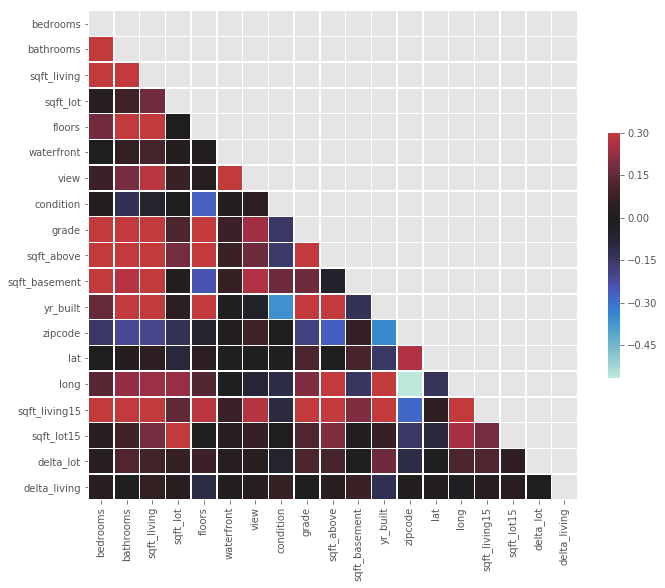

In [7]:
corr = df_pred.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
log_lot15 = np.log(df_pred.sqft_lot15) #Using the the log transformation to reduce postive skewness
log_above = np.log(df_pred.sqft_above)
#norm_basement = (df_pred.sqft_basement - df_pred.sqft_basement.mean()) / df_pred.sqft_basement.std() #I can't find anything that works #Basement has zero in it so we can't use log, we will use something else
log_living = np.log(df_pred.sqft_living)
log_living15 = np.log(df_pred.sqft_living15)
log_lot = np.log(df_pred.sqft_lot)

scaled_lot15 = (log_lot15-np.mean(log_lot15))/np.sqrt(np.var(log_lot15))
scaled_above = (log_above-np.mean(log_above))/np.sqrt(np.var(log_above))
#scaled_basement = (log_basement-np.mean(log_basement))/np.sqrt(np.var(log_basement))
scaled_living = (log_living-np.mean(log_living))/np.sqrt(np.var(log_living))
scaled_living15 = (log_living15-np.mean(log_living15))/np.sqrt(np.var(log_living15))
scaled_lot = (log_lot-np.mean(log_lot))/np.sqrt(np.var(log_lot))


df_pred_scaled = pd.DataFrame([])
df_pred_scaled['lot15'] = scaled_lot15
df_pred_scaled['above'] = scaled_above
#df_pred_scaled['basement'] = norm_basement
df_pred_scaled['living'] = scaled_living
df_pred_scaled['living15'] = scaled_living15
df_pred_scaled['lot'] = scaled_lot


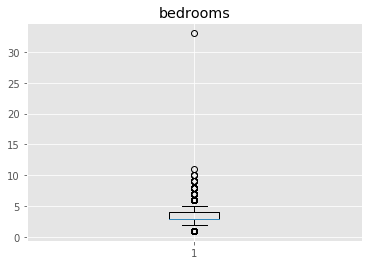

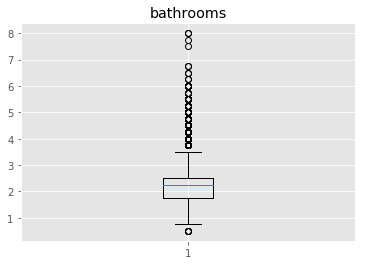

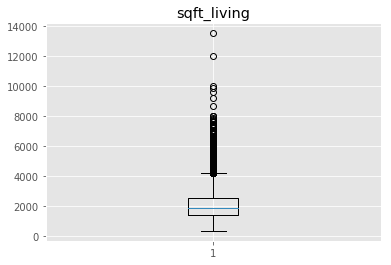

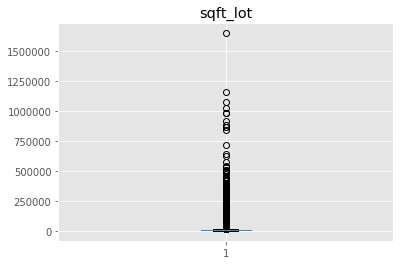

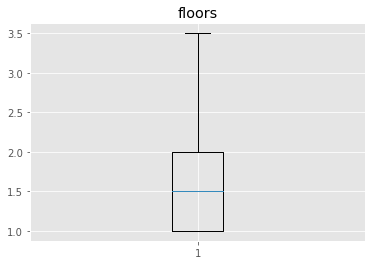

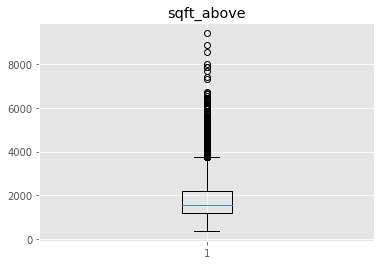

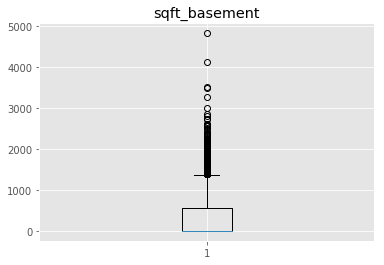

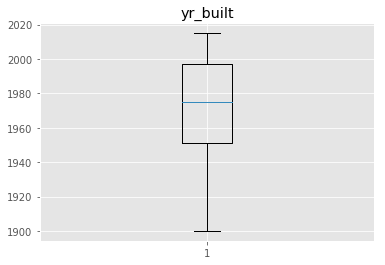

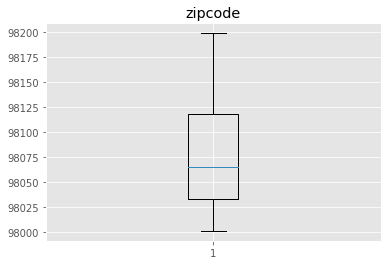

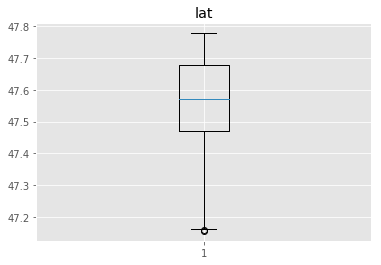

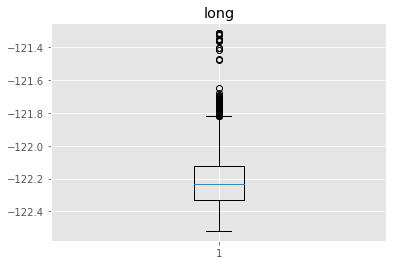

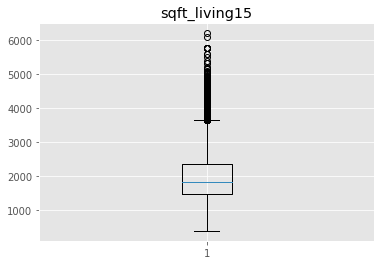

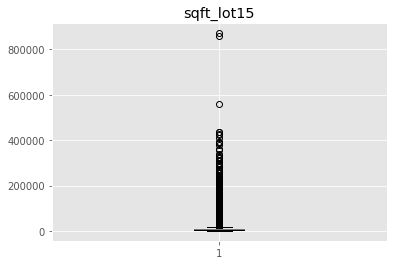

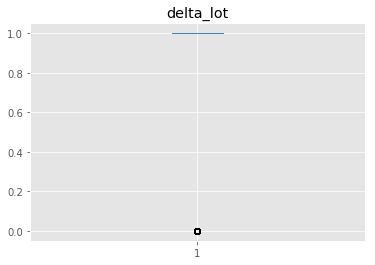

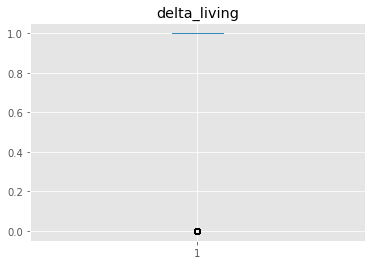

In [9]:
to_plot = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'delta_lot', 'delta_living']
for plot in to_plot:
    plt.boxplot(df_pred[plot])
    plt.title(plot)
    plt.show()

There seems to be a few outliers we have to remove. I will use the IQR to take care of them. Why? well I am really unsure. Do I do them on the standarized data or no? YES, you normalize then remove the outliers

In [10]:
def remove_outlier(df_in, col_names):
    df_out = pd.DataFrame([])
    for col in col_names:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_out

In [17]:
removing = ['living', 'lot', 'above', 'living15', 'lot15']
 = remove_outlier(df_pred_scaled, removing)

,lot15,above,living,living15,lot
0,-0.395459,-0.753583,-1.125582,-1.035453,-0.388439
1,-0.024288,0.672709,0.709463,-0.326789,-0.113243
2,0.042037,-1.752995,-2.131943,1.126531,0.244481
3,-0.545863,-1.026858,0.070676,-0.990210,-0.523926
4,-0.046395,0.073516,-0.292732,-0.134221,0.008140
6,-0.164030,0.121790,-0.244122,0.530887,-0.179963
7,0.271053,-1.004667,-1.378412,-0.399937,0.211971
8,0.049797,-1.026858,-0.156423,-0.168342,-0.078880
9,-0.035454,0.349271,-0.015060,0.731555,-0.222889
10,0.167185,0.311811,1.477660,0.492439,0.221632


In [30]:
bedroom_dummies = pd.get_dummies(df_pred.bedrooms, prefix="bedroom")
bathroom_dummies = pd.get_dummies(df_pred.bathrooms, prefix="bathroom")
floors_dummies = pd.get_dummies(df_pred.floors, prefix="floors")
view_dummies = pd.get_dummies(df_pred.view, prefix="view")
condition_dummies = pd.get_dummies(df_pred.condition, prefix="bedroom")
zipcode_dummies = pd.get_dummies(df_pred.zipcode)
grade_dummies = pd.get_dummies(df_pred.grade, prefix="grade")

#df_pred_scaled.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode'], axis=1,inplace=True)

df_pred_scaled = pd.concat([df_pred_scaled,bedroom_dummies,bathroom_dummies,floors_dummies,view_dummies,condition_dummies,zipcode_dummies,grade_dummies], axis=1)

## Lets check our inital model.

First I normalize my data, then I do the following steps

Replace feature_cols & X <br>
Train_test_split your data <br>
Fit the model to linreg again using linreg.fit <br>
Make predictions using (y_pred = linreg.predict(X_test)) <br>
Compute RMSE <br>
Repeat until RMSE satisfactory <br>

In [24]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

y = df[["price"]]
X = df_pred_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 #I couldn't figure out Kfolds well enough to use it.

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error")
cv_5_results
#predictors_int = sm.add_constant(df_pred_scaled)
#model = sm.OLS(df['price'],predictors_int).fit()
#model.summary()

array([-1.71724967e+27, -5.19459384e+26, -9.99780320e+28, -6.99213411e+27,
       -1.56463193e+28])

# Questions

The listed number of "bedroom"/"Bathroom" says more total square footage.


In [ ]:
df_pred_scaled.hist(figsize=(10,10))

In [ ]:
df_pred.describe()

In [ ]:
scatter = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'delta_lot',
       'delta_living']
price = df.price
for scatt in scatter:
    plt.scatter(y=price,x= df[scatt])
    plt.title(scatt)
    plt.show()

In [12]:
clean_up = ['sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'sqft_living15','sqft_lot15']

temp = remove_outlier(df_pred, clean_up)

In [ ]:
temp.describe()

Lets finally take care of our catigorial data.

In [ ]:
df_pred.drop('date', axis=1, inplace=True)
df_pred.columns

In [ ]:
eyJ2ZXJzaW9uIjoxLjMsImZlYXR1cmVzIjp7ImxvY2F0aW9uIjp7InJvb20iOnRydWUsIm91dHNpZGUiOnRydWV9fSwic3RvcmVzIjp7Indvb2QiOjc1LCJmdXIiOjExMi41LCJiYWl0Ijo2LCJzY2FsZXMiOjIsIm1lYXQiOjk4LjUsInRlZXRoIjoxMSwiY2xvdGgiOjF9LCJjaGFyYWN0ZXIiOnt9LCJpbmNvbWUiOnsiZ2F0aGVyZXIiOnsiZGVsYXkiOjEwLCJzdG9yZXMiOnsid29vZCI6Mn0sInRpbWVMZWZ0IjoxMH0sImJ1aWxkZXIiOnsiZGVsYXkiOjEwLCJzdG9yZXMiOnsid29vZCI6Mn0sInRpbWVMZWZ0Ijo5fSwiaHVudGVyIjp7ImRlbGF5IjoxMCwic3RvcmVzIjp7ImZ1ciI6MS41LCJtZWF0IjoxLjV9LCJ0aW1lTGVmdCI6OH0sInRyYXBwZXIiOnsiZGVsYXkiOjEwLCJzdG9yZXMiOnsibWVhdCI6LTIsImJhaXQiOjJ9LCJ0aW1lTGVmdCI6OH19LCJ0aW1lcnMiOnt9LCJnYW1lIjp7ImJ1aWxkZXIiOnsibGV2ZWwiOjR9LCJ0ZW1wZXJhdHVyZSI6eyJ2YWx1ZSI6NCwidGV4dCI6ImhvdCJ9LCJmaXJlIjp7InZhbHVlIjo0LCJ0ZXh0Ijoicm9hcmluZyJ9LCJidWlsZGluZ3MiOnsiY2FydCI6MSwidHJhcCI6NCwiaHV0IjoyLCJsb2RnZSI6MX0sInBvcHVsYXRpb24iOjcsIndvcmtlcnMiOnsiaHVudGVyIjozLCJ0cmFwcGVyIjoyfSwib3V0c2lkZSI6eyJzZWVuRm9yZXN0Ijp0cnVlfX0sInBsYXlTdGF0cyI6e30sInByZXZpb3VzIjp7fSwib3V0Zml0Ijp7fSwiY29uZmlnIjp7ImxpZ2h0c09mZiI6dHJ1ZX0sImNvb2xkb3duIjp7InRyYXBzQnV0dG9uIjo1OSwiZ2F0aGVyQnV0dG9uIjo0MH19